In [30]:
import numpy as np
import pandas as pd

Read in the postal codes from the Wikipedia page.

In [42]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Drop rows containing 'Not assigned' for Borough.

In [43]:
df = df[~df.Borough.str.contains("Not assigned")]
df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Determine if any rows have duplicate postal codes.

In [44]:
df.describe()

,Postal Code,Borough,Neighbourhood
count,103,103,103
unique,103,10,99
top,M4W,North York,Downsview
freq,1,24,4


All rows contain a unique postal code, so there is no need to concatenate by Neighbourhood. This has already been completed on the Wikipedia page.

Next, determine if any rows contain 'Not assigned' for Neighbourhood after dropping such rows from the Borough column.

In [45]:
df[df.Neighbourhood.str.contains("Not assigned")].describe()

,Postal Code,Borough,Neighbourhood
count,0,0,0
unique,0,0,0


Again, there are no cells which meet this criterion. So there is no need to assign the same Borough name as the Neighbourhood.

Now load in the geospatial data CSV into a separate dataframe.

In [46]:
df2 = pd.read_csv('https://cocl.us/Geospatial_data')

In [47]:
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the two tables using the Postal Code column.

In [54]:
df = df.merge(df2,on = 'Postal Code', how = 'inner')
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Now let's start the clustering part of the assignment.

In [63]:
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Let's take a look at a map of Toronto with all neighborhoods superimposed onto it.

In [65]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Kreutzfeldt-Coursera-Capstone")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [67]:
# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Foursquare Credentials (delete before uploading to GitHub)

In [70]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Define some useful functions to use in conjunction with the Foursquare API.

In [81]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

And now let's get the Toronto venues

In [82]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

We now must restructure the pandas dataframe according to the category of the venue and group these by neighborhood. This will drastically reduce the size of the dataframe we are working with and make it more manageable. To do this, we will make the value of the venue category a mean value of all venues in the neighborhood.

In [88]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Agincourt,0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.000,0.000,...,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
1,"Alderwood, Long Branch",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.000,0.000,...,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.000,0.000,...,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
3,Bayview Village,0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.000,0.000,...,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
4,"Bedford Park, Lawrence Manor East",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.000,0.000,...,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
5,Berczy Park,0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.000,0.000,...,0.00,0.00,0.017241,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
6,"Birch Cliff, Cliffside West",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.000,0.000,...,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.000,0.000,...,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
8,"Business reply mail Processing Centre, South C...",0.058824,0.0,0.000000,0.000000,0.0000,0.0000,0.000,0.000,0.000,...,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.000000,0.062500,0.0625,0.0625,0.125,0.125,0.125,...,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.000000


Before we perform the clustering, let's first see what the 10 most common venue types in each neighborhood is.

In [115]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Latin American Restaurant,Lounge,Skating Rink,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Sandwich Place,Pub,Discount Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Sandwich Place,Supermarket,Ice Cream Shop,Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Shopping Mall,Deli / Bodega
3,Bayview Village,Café,Bank,Chinese Restaurant,Japanese Restaurant,Women's Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Pizza Place,Sandwich Place,Italian Restaurant,Thai Restaurant,Indian Restaurant,Butcher,Café,Sushi Restaurant,Pub


## Clustering

The first step in K means clustering is to determine the appropriate K value by finding the elbow point.

In [119]:
X = toronto_grouped.values[:,1:]

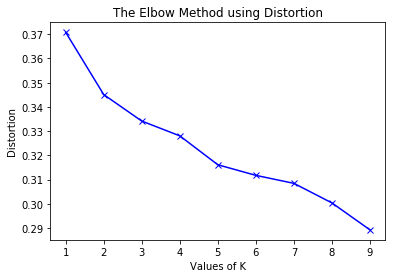

In [126]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt  


distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10)

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

for k in K: 
    #Building and fitting the model 
    kmeanModel = kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

Based on the plot, it looks like the elbow point is at k = 5.

In [112]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,3.0,Park,Food & Drink Shop,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Portuguese Restaurant,Coffee Shop,Intersection,Hockey Arena,French Restaurant,Pizza Place,Drugstore,Donut Shop,Doner Restaurant,Dog Run
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Park,Bakery,Café,Pub,Breakfast Spot,Theater,Spa,Shoe Store,Brewery
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Furniture / Home Store,Accessories Store,Coffee Shop,Event Space,Arts & Crafts Store,Boutique,Miscellaneous Shop,Vietnamese Restaurant,Eastern European Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,Coffee Shop,Sushi Restaurant,Gym,Discount Store,Sandwich Place,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Hobby Shop


Weirdly, there are some neighborhoods that don't have any venues, and therefore return NaN for their cluster labels. Therefore, we must restructure the dataframe to remove these rows.

In [132]:
toronto_merged.dropna(inplace=True)

Finally, let's lee the clusters on the map.

In [133]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now, let's see what the venues in our clusters look like to assign labels.

In [114]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
51,Scarborough,0.0,Motel,American Restaurant,Women's Store,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run


In [127]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,1.0,Portuguese Restaurant,Coffee Shop,Intersection,Hockey Arena,French Restaurant,Pizza Place,Drugstore,Donut Shop,Doner Restaurant,Dog Run
2,Downtown Toronto,1.0,Coffee Shop,Park,Bakery,Café,Pub,Breakfast Spot,Theater,Spa,Shoe Store,Brewery
3,North York,1.0,Clothing Store,Furniture / Home Store,Accessories Store,Coffee Shop,Event Space,Arts & Crafts Store,Boutique,Miscellaneous Shop,Vietnamese Restaurant,Eastern European Restaurant
4,Downtown Toronto,1.0,Coffee Shop,Sushi Restaurant,Gym,Discount Store,Sandwich Place,Park,Mexican Restaurant,Japanese Restaurant,Italian Restaurant,Hobby Shop
7,North York,1.0,Gym,Beer Store,Japanese Restaurant,Restaurant,Coffee Shop,Clothing Store,Italian Restaurant,Dim Sum Restaurant,Supermarket,Caribbean Restaurant
8,East York,1.0,Pizza Place,Pet Store,Flea Market,Breakfast Spot,Gym / Fitness Center,Bank,Pharmacy,Intersection,Athletics & Sports,Gastropub
9,Downtown Toronto,1.0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Hotel,Middle Eastern Restaurant,Bubble Tea Shop,Japanese Restaurant,Italian Restaurant,Theater
10,North York,1.0,Park,Japanese Restaurant,Pizza Place,Bakery,Pub,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
12,Scarborough,1.0,Construction & Landscaping,Bar,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
13,North York,1.0,Gym,Beer Store,Japanese Restaurant,Restaurant,Coffee Shop,Clothing Store,Italian Restaurant,Dim Sum Restaurant,Supermarket,Caribbean Restaurant


In [128]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Scarborough,2.0,Fast Food Restaurant,Department Store,Event Space,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant


In [129]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,3.0,Park,Food & Drink Shop,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
21,York,3.0,Park,Pool,Women's Store,Golf Course,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant
35,East York,3.0,Park,Convenience Store,Intersection,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
52,North York,3.0,Park,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
64,York,3.0,Park,Convenience Store,Jewelry Store,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
66,North York,3.0,Convenience Store,Park,Women's Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
85,Scarborough,3.0,Park,Playground,Intersection,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
91,Downtown Toronto,3.0,Park,Trail,Playground,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
98,Etobicoke,3.0,Park,River,Pool,Discount Store,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center


In [130]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,North York,4.0,Baseball Field,Food Service,Women's Store,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dessert Shop
101,Etobicoke,4.0,Baseball Field,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Women's Store,Farmers Market


Based on this information, I would assign the following labels:
- k = 0: Tourist district
- k = 1: Everything else
- k = 2: Retail district
- k = 3: Parks
- k = 4: Sports stadiums